# 5. FOR ALL INTERVALS IN TEST SET: get overall test set results

Investigate nan MAPE for naive below.

In [1]:
import pickle
import pandas as pd
import numpy as np
import shutil
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid", font_scale=1.5)
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

In [2]:
# Import all corrected (test) files
spacecraft = "wind"
n_bins = 10

#input_files = sorted(glob.glob("data/processed/psp/test/psp_*_corrected.pkl"))
input_files = sorted(glob.glob("data/processed/wind/wi_*_corrected.pkl"))

files_metadata, ints_metadata, ints, ints_gapped_metadata, ints_gapped, sfs, sfs_gapped_corrected = sf.load_and_concatenate_dataframes(
    input_files)

# Also get the 2d heatmap for final case study correction figure, by undoing the above operation

with open(f"data/processed/heatmap_2d_{n_bins}bins.pkl", "rb") as f:
    data = pickle.load(f)

heatmap_bin_vals_2d = data["heatmap_bin_vals_2d"]
heatmap_bin_edges_2d = data["heatmap_bin_edges_2d"]

In [3]:
sfs_gapped_corrected.gap_handling.unique()

array(['naive', 'lint', 'corrected_2d', 'corrected_3d'], dtype=object)

### Box plots

In [4]:
ints_gapped_metadata.groupby("gap_handling")[["missing_percent_overall", "slope", "slope_pe", "mpe", "mape"]].agg(["mean", "median", "std", "min", "max"])

missing_percent_overall                                  \
                                mean median        std    min    max   
gap_handling                                                           
corrected_2d               41.723333  45.55  21.879801  14.97  82.08   
corrected_3d               41.723333  45.55  21.879801  14.97  82.08   
lint                       41.723333  45.55  21.879801  14.97  82.08   
naive                      41.723333  45.55  21.879801  14.97  82.08   

                 slope                                          ...  \
                  mean    median       std       min       max  ...   
gap_handling                                                    ...   
corrected_2d  0.770928  0.749563  0.084146  0.636770  0.883341  ...   
corrected_3d  0.783167  0.696042  0.306700  0.527428  1.529636  ...   
lint          0.787158  0.756915  0.085142  0.662747  0.899014  ...   
naive         0.764643  0.738372  0.093731  0.656641  0.923726  ...   

                    mpe                                               \
                   mean     median        std        min         max   
gap_handling                                                           
corrected_2d  26.606934  13.036954  47.616904 -28.248872  121.472683   
corrected_3d  12.009982   4.456581  25.241781 -15.532489   48.456253   
lint         -27.564578 -26.426942  21.075590 -54.734011    2.017157   
naive         11.512734  -4.701953  45.493077 -28.791223  122.685661   

                   mape                                              
                   mean     median        std       min         max  
gap_handling                                                         
corrected_2d  38.921608  28.248872  39.480173  5.913139  121.472683  
corrected_3d  26.097063  13.112878  17.714955  7.876718   49.226388  
lint          28.740450  26.426942  19.341479  4.359882   54.734011  
naive         30.069317  18.430406  36.332885  8.060011  122.685661  

[4 rows x 25 columns]

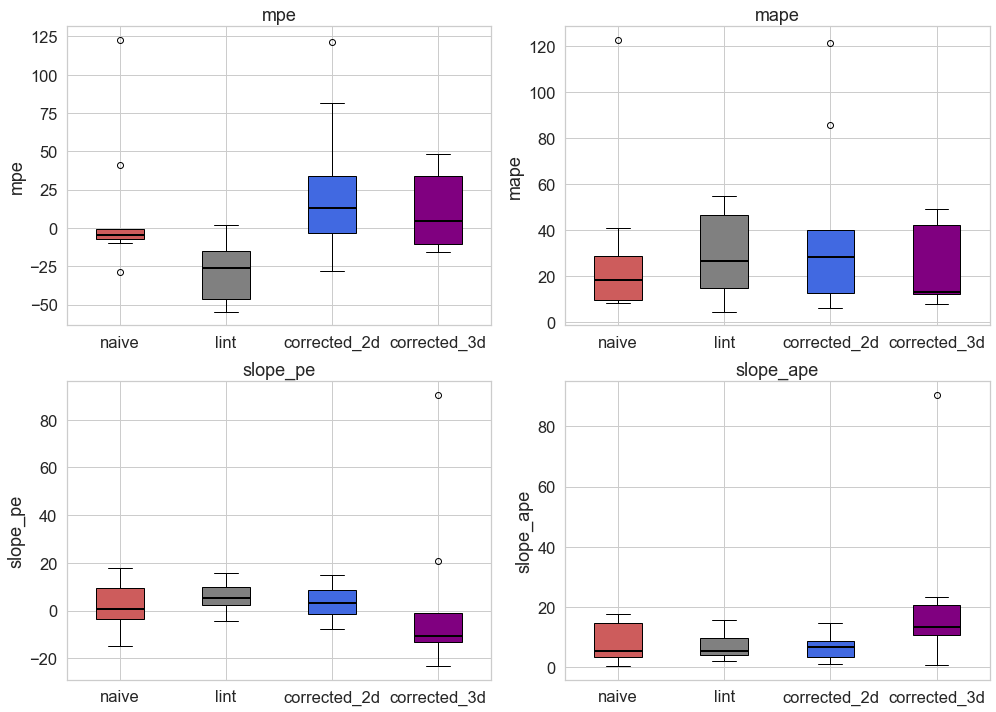

In [5]:
import matplotlib.pyplot as plt

# Assuming ints_gapped_metadata is your DataFrame
# Define the list of columns to plot
columns = ["mpe", "mape", "slope_pe", "slope_ape"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

custom_order = ["naive", "lint", "corrected_2d", "corrected_3d"]
colors = ['indianred', 'grey', 'royalblue', 'purple']

# Create boxplots for each column
for col, ax in zip(columns, axes):
    data_to_plot = [ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == method][col] for method in custom_order]
    box = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Set colors for the boxes
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set colors for the median lines
    median_color = 'black'
    for median in box['medians']:
        median.set_color(median_color)
        median.set_linewidth(2)  # optional: set line width to make it more prominent

    ax.set_title(f'{col}')
    ax.set_ylabel(f'{col}')
    ax.set_xticklabels(custom_order)

# Adjust layout
plt.tight_layout()
plt.suptitle('')  # Remove the default title to avoid overlap
plt.savefig(f"plots/temp/test_{spacecraft}_boxplots.jpg", bbox_inches='tight')

### Regression lines

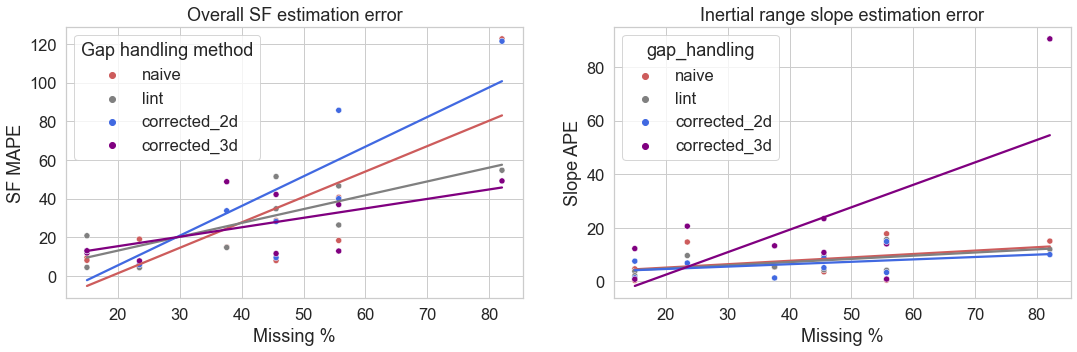

In [25]:
# Make scatterplot of mape vs. missing_percent, coloured by gap handling
palette = dict(zip(custom_order, colors))

# Plotting the MAPE vs. missing percentage
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(data=ints_gapped_metadata, x="missing_percent_overall", y="mape", hue="gap_handling", palette=palette, ax = ax[0])
ax[0].legend(title="Gap handling method")

# Add regression lines for each group
unique_gap_handling = ints_gapped_metadata['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="mape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[0])

sns.scatterplot(data=ints_gapped_metadata, x="missing_percent_overall", y="slope_ape", hue="gap_handling", palette=palette, ax = ax[1])

# Add regression lines for each group

unique_gap_handling = ints_gapped_metadata['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_gapped_metadata[ints_gapped_metadata['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="slope_ape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[1])
    
ax[0].set_xlabel("Missing %")
ax[0].set_ylabel("SF MAPE")
ax[0].set_title("Overall SF estimation error")
ax[1].set_xlabel("Missing %")
ax[1].set_ylabel("Slope APE")
ax[1].set_title("Inertial range slope estimation error")

plt.savefig(f"plots/temp/test_{spacecraft}_scatterplots.jpg", bbox_inches='tight')

### Error trendlines

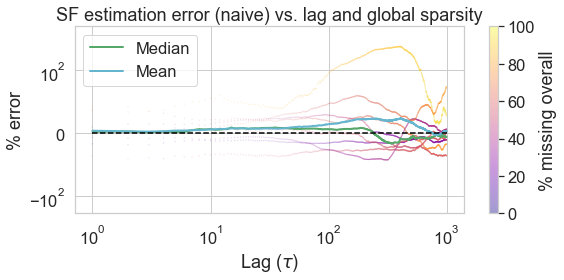

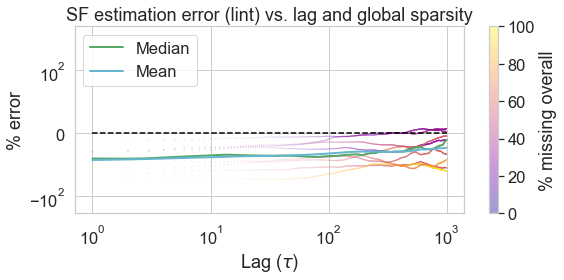

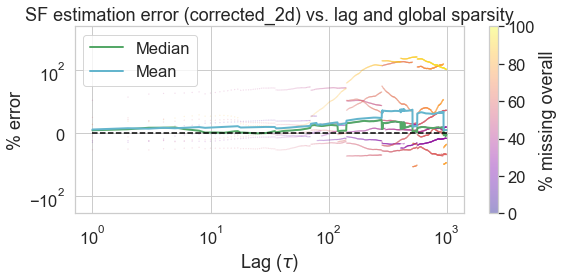

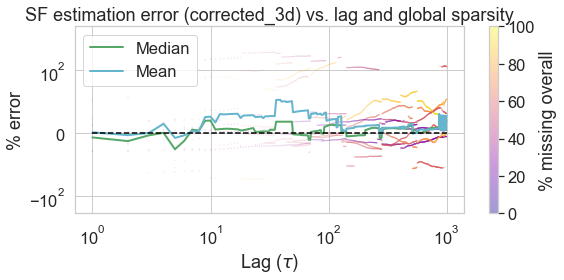

In [7]:
for gap_handling in sfs_gapped_corrected.gap_handling.unique():
    sf.plot_error_trend_line(sfs_gapped_corrected[sfs_gapped_corrected["gap_handling"]==gap_handling], estimator="sf_2", title = f"SF estimation error ({gap_handling}) vs. lag and global sparsity", y_axis_log=True)
    plt.savefig(f"plots/temp/test_{spacecraft}_error_trend_{gap_handling}.jpg", bbox_inches='tight')

### 5d. Pre-correction case studies

   file_index  int_index  version  missing_percent_overall  gap_handling  \
0           3          0        0                    45.55         naive   
1           3          0        0                    45.55          lint   
6           3          0        0                    45.55  corrected_2d   
7           3          0        0                    45.55  corrected_3d   

        mape   slope_pe  
0  28.791223   9.242242  
1  51.478051   9.626493  
6  28.248872   8.793617  
7  42.228357 -23.447556  
   file_index  int_index  version  missing_percent_overall  gap_handling  \
2           3          0        1                    55.68         naive   
3           3          0        1                    55.68          lint   
8           3          0        1                    55.68  corrected_2d   
9           3          0        1                    55.68  corrected_3d   

        mape   slope_pe  
2  18.430406   0.494225  
3  26.426942   4.184562  
8  85.753897   3.351687  
9  3

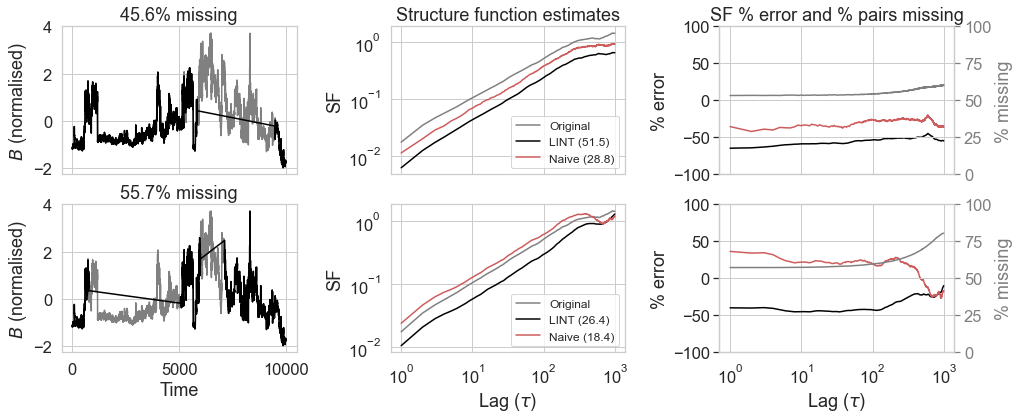

In [22]:
# Below variables say to plot two versions of the first interval

file_index = ints_gapped_metadata["file_index"].unique()[0]
int_index=0
num_version_to_plot = 2

fig, ax = plt.subplots(num_version_to_plot, 3, figsize=(16, num_version_to_plot*3))

for version in range(num_version_to_plot):
    ax[version, 0].plot(ints[0][int_index][0].values, c = "grey")
    ax[version, 0].plot(
        ints_gapped.loc[
            (ints_gapped["file_index"]==file_index) &
            (ints_gapped["int_index"]==int_index) & 
            (ints_gapped["version"]==version) & 
            (ints_gapped["gap_handling"]=="lint"), "B"].values, c="black")

    # Put missing_percent_overall in the title
    ax[version, 0].set_title(f"{ints_gapped_metadata.loc[(ints_gapped_metadata['file_index']==file_index) & (ints_gapped_metadata['int_index']==int_index) & (ints_gapped_metadata['version']==version) & (ints_gapped_metadata['gap_handling']=='lint'), 'missing_percent_overall'].values[0]:.1f}% missing")

    # Plot the SF
    ax[version, 1].plot(
        sfs.loc[(sfs["file_index"]==file_index) & (sfs["int_index"]==int_index), "lag"],
        sfs.loc[(sfs["file_index"]==file_index) & (sfs["int_index"]==int_index), "sf_2"], c="grey", label = "Original")

    ax[version, 1].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2"], c="black", 
                        label="LINT ({:.1f})".format(ints_gapped_metadata.loc[
                            (sfs_gapped_corrected["file_index"]==file_index) &
                            (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="lint"), "mape"].values[0]),)
    ax[version, 1].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2"], c="indianred",
                        label="Naive ({:.1f})".format(ints_gapped_metadata.loc[
                            (sfs_gapped_corrected["file_index"]==file_index) &
                            (ints_gapped_metadata["int_index"]==int_index) &
                                        (ints_gapped_metadata["version"]==version) &
                                        (ints_gapped_metadata["gap_handling"]=="naive"), "mape"].values[0]),)
    
    # Plot the sf_2_pe
    ax[version, 2].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2_pe"], c="black")
    ax[version, 2].plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2_pe"], c="indianred")
    
    # plot sample size n on right axis
    ax2 = ax[version, 2].twinx()
    ax2.plot(
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) & 
                       (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"], 
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & 
                        (sfs_gapped_corrected["version"]==version) & 
                        (sfs_gapped_corrected["gap_handling"]=="naive"), "missing_percent"], c="grey")

    # Label the axes
    ax[1, 0].set_xlabel("Time")
    ax[version, 0].set_ylabel("$B$ (normalised)")
    ax[1, 1].set_xlabel("Lag ($\\tau$)")
    ax[version, 1].set_ylabel("SF")
    ax[1, 2].set_xlabel("Lag ($\\tau$)")
    ax[version, 2].set_ylabel("% error")
    ax2.set_ylabel("% missing", color="grey")
    ax2.tick_params(axis="y", colors="grey")
    ax2.set_ylim(0,100)

    #ax[version, 2].axhline(0, c="black", linestyle="--")
    ax[version, 2].set_ylim(-100, 100)

    ax[version, 1].set_xscale("log")
    ax[version, 1].set_yscale("log")
    ax[version, 2].set_xscale("log")
    ax[version, 1].legend(fontsize=12)
    [ax[0, i].set_xticklabels([]) for i in range(3)]

    print(
        ints_gapped_metadata.loc[
            (ints_gapped_metadata["file_index"]==file_index) &
            (ints_gapped_metadata["int_index"]==int_index) & 
            (ints_gapped_metadata["version"]==version)]
            [["file_index", "int_index", "version", "missing_percent_overall", "gap_handling", "mape", "slope_pe"]])


# Add titles
ax[0, 1].set_title("Structure function estimates")
ax[0, 2].set_title("SF % error and % pairs missing")
plt.subplots_adjust(wspace=0.4)

plt.savefig(f"plots/temp/test_{spacecraft}_case_study_gapping_{file_index}_{int_index}.jpg", bbox_inches='tight')

### 5e. Corrected case studies

In [23]:
# Annotate each heatmap trace with info
def annotate_curve(ax, x, y, text, offset_scaling=(0.3, 0.1)):
    # Find the index of y value closest to the median value
    idx = np.argmin(np.abs(y - np.percentile(y, 20)))

    # Coordinates of the point of maximum y value
    x_max = x.iloc[idx]
    y_max = y.iloc[idx]

    # Convert offset from axes fraction to data coordinates
    x_text = 10 ** (offset_scaling[0] * np.log10(x_max))  # Log-axis
    y_text = y_max + offset_scaling[1] * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Annotate with the text, adjusting the position with xytext_offset
    ax.annotate(
        text,
        xy=(x_max, y_max - 1),
        xytext=(x_text, y_text),
        # xycoords="axes fraction",
        # textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round", alpha=0.7),
    )

   int_index  version  missing_percent_overall  gap_handling       mape  \
0          0        0                    45.55         naive  28.791223   
1          0        0                    45.55          lint  51.478051   
6          0        0                    45.55  corrected_2d  28.248872   
7          0        0                    45.55  corrected_3d  42.228357   

    slope_pe  
0   9.242242  
1   9.626493  
6   8.793617  
7 -23.447556  
   int_index  version  missing_percent_overall  gap_handling       mape  \
2          0        1                    55.68         naive  18.430406   
3          0        1                    55.68          lint  26.426942   
8          0        1                    55.68  corrected_2d  85.753897   
9          0        1                    55.68  corrected_3d  36.991756   

    slope_pe  
2   0.494225  
3   4.184562  
8   3.351687  
9 -14.017331  


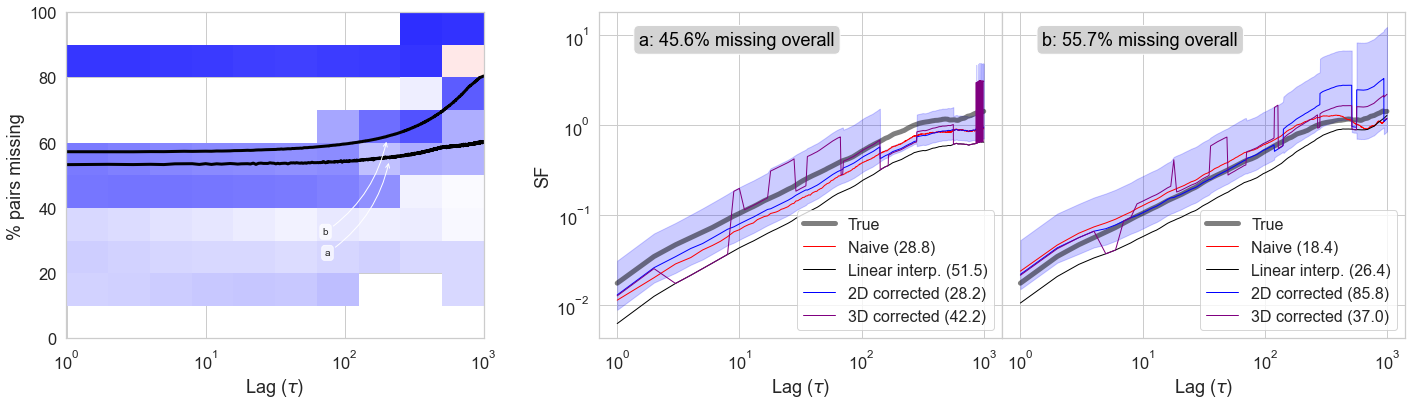

In [24]:
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec layout with specified width ratios and horizontal space
gs1 = GridSpec(1, 1, left=0.06, right=0.35)
gs2 = GridSpec(1, 2, left=0.43, right=0.99, wspace=0)

# Create subplots
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs2[0, 0])

for version in range(2):

    if version == 0:
        ax = ax1
        ax.set_ylabel("SF")
    else:
        ax = fig.add_subplot(gs2[0, version], sharey=ax1)
        plt.setp(ax.get_yticklabels(), visible=False)
        
    ax.plot(
        sfs[(sfs["file_index"]==file_index) & (sfs["int_index"]==int_index)]["lag"],
        sfs[(sfs["file_index"]==file_index) & (sfs["int_index"]==int_index)]["sf_2"],
        color="black",
        label="True",
        lw=5,
        alpha=0.5,
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="naive"), "lag"],
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="naive"), "sf_2"],
        color="red",
        lw=1,
        label="Naive ({:.1f})".format(ints_gapped_metadata.loc[
            (ints_gapped_metadata["file_index"]==file_index) &
            (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="naive"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"],
        sfs_gapped_corrected.loc[
                        (sfs_gapped_corrected["file_index"]==file_index) &            
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "sf_2"],
        color="black",
        lw=1,
        label="Linear interp. ({:.1f})".format(ints_gapped_metadata.loc[
                        (ints_gapped_metadata["file_index"]==file_index) &            
            (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="lint"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[
            (sfs_gapped_corrected["file_index"]==file_index) &
            (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2"],
        color="blue",
        lw=1,
        label="2D corrected ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["file_index"]==file_index) &                         (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="corrected_2d"), "mape"].values[0]),
    )
    ax.plot(
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "sf_2"],
        color="purple",
        lw=1,
        label="3D corrected ({:.1f})".format(ints_gapped_metadata.loc[(ints_gapped_metadata["file_index"]==file_index) &                         (ints_gapped_metadata["int_index"]==int_index) &
                                                                (ints_gapped_metadata["version"]==version) &
                                                                (ints_gapped_metadata["gap_handling"]=="corrected_3d"), "mape"].values[0]),
    )
    ax.fill_between(
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2_lower"],
            sfs_gapped_corrected.loc[             (sfs_gapped_corrected["file_index"]==file_index) &                         (sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_2d"), "sf_2_upper"],
        color="blue",
        alpha=0.2,
    )

    missing = ints_gapped_metadata.loc[
        (ints_gapped_metadata["file_index"] == file_index) & 
        (ints_gapped_metadata["int_index"] == int_index) & (ints_gapped_metadata["version"] == version),
        "missing_percent_overall"
    ].values

    ax.legend(loc="lower right", fontsize = 16)
    ax.semilogx()
    ax.semilogy()


    # PLOTTING HEATMAP IN FIRST PANEL

    c = ax0.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],  # convert to % Missing
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=ax0, label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    ax0.set_xlabel("Lag ($\\tau$)")
    ax0.plot(
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "lag"],
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="corrected_3d"), "missing_percent"],
        c="black",
        lw=3,
    )

    # Label test intervals with letters
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    annotate_curve(
        ax0,
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "lag"],
        sfs_gapped_corrected.loc[(sfs_gapped_corrected["file_index"]==file_index) &(sfs_gapped_corrected["int_index"]==int_index) & (sfs_gapped_corrected["version"]==version) & 
                                                                        (sfs_gapped_corrected["gap_handling"]=="lint"), "missing_percent"],
        f"{alphabet[version]}",
        offset_scaling=(0.8, -0.3),
    )

    ax.annotate(
        f"{alphabet[version]}: {float(missing[0]):.1f}% missing overall",
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.1, 0.9),
        textcoords="axes fraction",
        transform=ax.transAxes,
        c="black",
        fontsize=18,
        bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round"),
    )


    ax.set_xlabel("Lag ($\\tau$)")

    print(
        ints_gapped_metadata.loc[
            (ints_gapped_metadata["file_index"]==file_index) & 
            (ints_gapped_metadata["int_index"]==int_index) & 
            (ints_gapped_metadata["version"]==version)]
            [["int_index", "version", "missing_percent_overall", "gap_handling", "mape", "slope_pe"]])

    
ax0.set_xscale("log")
ax0.set_xlabel("Lag ($\\tau$)")
ax0.set_ylabel("% pairs missing")
ax0.set_ylim(0, 100)

plt.savefig(f"plots/temp/test_{spacecraft}_case_study_correcting_{file_index}_{int_index}.jpg", bbox_inches='tight')